# &#x1F4D1; &nbsp;  Keras Cookbook
## 0. Code Library and Links

In [13]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: darkgreen; font-family: 'Roboto';} 
h1 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;} 
h2, h3 {color: darkslategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #aaa;}
h4 {color: slategray; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ddd;}
div.input_prompt, div.output_area pre {color: slategray;}
div.output_prompt {color: green;}     
</style>

In [14]:
import numpy as np 
import pandas as pd
import os
import json

import scipy
import cv2
import seaborn
import time

import keras

from PIL import ImageFile
from IPython.display import SVG
from tqdm import tqdm
from skimage import data

import matplotlib.pylab as plt
from matplotlib import cm

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [15]:
from keras.datasets import mnist, cifar10, imdb, boston_housing

In [16]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files  

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import sequence as keras_sequence
from keras.preprocessing import image as keras_image

from keras.utils import to_categorical, np_utils
from keras.utils.vis_utils import model_to_dot

In [18]:
from keras.models import Sequential, Model
from keras.models import load_model, model_from_json

In [19]:
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.embeddings import Embedding
from keras.layers.advanced_activations import PReLU
from keras.layers import Dense, LSTM, GlobalMaxPooling2D
from keras.layers import Activation, Flatten, Dropout
from keras.layers import Input, BatchNormalization

In [20]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input

In [21]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_preprocess_input

In [22]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [23]:
def loss_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['loss'], label = 'train')
    plt.plot(fit_history.history['val_loss'], label = 'test')

    plt.legend()
    plt.title('Loss Function');  
    
def mae_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['mean_absolute_error'], label = 'train')
    plt.plot(fit_history.history['val_mean_absolute_error'], label = 'test')

    plt.legend()
    plt.title('Mean Absolute Error'); 

def acc_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['acc'], label = 'train')
    plt.plot(fit_history.history['val_acc'], label = 'test')

    plt.legend()
    plt.title('Accuracy');     

In [24]:
def decode_predictions2(preds, fpath, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        results.append(result)
    return results

## 1. Backend

In [25]:
'''
/.keras/keras.json
{"image_data_format": "channels_last",
 "epsilon": 1e-07,
 "floatx": "float32",
 "backend": "tensorflow"}
'''
''''''

''

In [26]:
# variants: "theano", "tensorflow", "cntk"
keras.backend.backend()

'tensorflow'

In [27]:
keras.backend.image_dim_ordering()

'tf'

## 2. Data
### internal datasets

In [28]:
# 32x32 color images; 50,000 - the train set; 10,000 - the test set; labeled over 10 categories
(x_train1, y_train1), (x_test1, y_test1) = cifar10.load_data()

In [29]:
n = int(len(x_test1)/2)
x_valid1, y_valid1 = x_test1[:n], y_test1[:n]
x_test1, y_test1 = x_test1[n:], y_test1[n:]
print(x_train1.shape, x_valid1.shape, x_test1.shape)
print(y_train1.shape, y_valid1.shape, y_test1.shape)

(50000, 32, 32, 3) (5000, 32, 32, 3) (5000, 32, 32, 3)
(50000, 1) (5000, 1) (5000, 1)


Label:  9


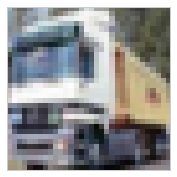

In [30]:
print('Label: ', y_train1[1][0])
plt.figure(figsize=(3,3)); plt.xticks([]); plt.yticks([])
plt.imshow(x_train1[1]);

In [31]:
# 28x28 grayscale images; 55,000 - the train set; 10,000 - the test set; labeled over 10 categories
(x_train2, y_train2), (x_test2, y_test2) = mnist.load_data()

In [32]:
n = int(len(x_test2)/2)
x_valid2, y_valid2 = x_test2[:n], y_test2[:n]
x_test2, y_test2 = x_test2[n:], y_test2[n:]
print(x_train2.shape, x_valid2.shape, x_test2.shape)
print(y_train2.shape, y_valid2.shape, y_test2.shape)

(60000, 28, 28) (5000, 28, 28) (5000, 28, 28)
(60000,) (5000,) (5000,)


Label:  0


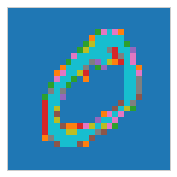

In [33]:
print('Label: ', y_train2[1])
plt.figure(figsize=(3,3)); plt.xticks([]); plt.yticks([])
plt.imshow(x_train2[1], cmap='tab10');

In [34]:
# 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative)
num_words, max_length, embedding_vector_length = 10000, 1000, 32
(x_train3, y_train3), (x_test3, y_test3) = imdb.load_data(path="imdb_full.pkl", num_words=num_words,
                                                          skip_top=0, maxlen=max_length, seed=113,
                                                          start_char=1, oov_char=2, index_from=3)

In [35]:
n = int(len(x_test3)/2)
x_valid3, y_valid3 = x_test3[:n], y_test3[:n]
x_test3, y_test3 = x_test3[n:], y_test3[n:]
print(x_train3.shape, x_valid3.shape, x_test3.shape)
print(y_train3.shape, y_valid3.shape, y_test3.shape)

(25000,) (12409,) (12410,)
(25000,) (12409,) (12410,)


In [36]:
print('Label: ', y_train3[1])
print('Sequence of word indexes: \n', x_train3[1])

Label:  0
Sequence of word indexes: 
 [1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 8163, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 6853, 5, 163, 11, 3215, 2, 4, 1153, 9, 194, 775, 7, 8255, 2, 349, 2637, 148, 605, 2, 8003, 15, 123, 125, 68, 2, 6853, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 8255, 5, 2, 656, 245, 2350, 5, 4, 9837, 131, 152, 491, 18, 2, 32, 7464, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]


In [37]:
# 13 attributes of houses at different locations, targets are the median values of the houses at a location (in k$)
(x_train4, y_train4), (x_test4, y_test4) =  boston_housing.load_data()

In [38]:
n = int(len(x_test4)/2)
x_valid4, y_valid4 = x_test4[:n], y_test4[:n]
x_test4, y_test4 = x_test4[n:], y_test4[n:]
print(x_train4.shape, x_valid4.shape, x_test4.shape)
print(y_train4.shape, y_valid4.shape, y_test4.shape)

(404, 13) (51, 13) (51, 13)
(404,) (51,) (51,)


In [39]:
print('Target value: ', y_train4[1])
print("Features' values: \n", x_train4[1])

Target value:  42.3
Features' values: 
 [2.1770e-02 8.2500e+01 2.0300e+00 0.0000e+00 4.1500e-01 7.6100e+00
 1.5700e+01 6.2700e+00 2.0000e+00 3.4800e+02 1.4700e+01 3.9538e+02
 3.1100e+00]


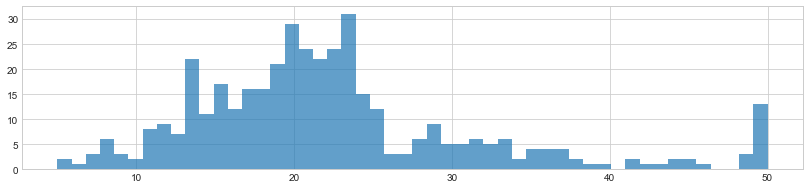

In [40]:
plt.figure(figsize=(14, 3))
plt.hist(y_train4, bins=50, alpha=0.7);

### artificial datasets

In [41]:
# Classification; the artificial set, labeled over 2 categories 
X5, Y5 = make_classification(n_samples=5000, n_features=2, n_redundant=0, n_informative=2)
x_train5, x_test5, y_train5, y_test5 = train_test_split(X5, Y5, test_size = 0.2, random_state = 1)

In [42]:
n = int(len(x_test5)/2)
x_valid5, y_valid5 = x_test5[:n], y_test5[:n]
x_test5, y_test5 = x_test5[n:], y_test5[n:]
print(x_train5.shape, x_valid5.shape, x_test5.shape)
print(y_train5.shape, y_valid5.shape, y_test5.shape)

(4000, 2) (500, 2) (500, 2)
(4000,) (500,) (500,)


In [43]:
print('Label: ', y_train5[1])
print('Features: \n', x_train5[1])

Label:  0
Features: 
 [-0.68760779 -0.88166915]


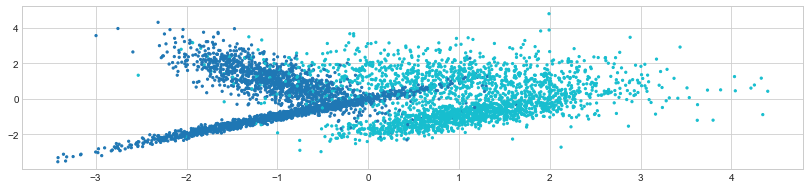

In [44]:
plt.figure(figsize=(14,3)) 
plt.scatter(X5[:, 0], X5[:, 1], marker='o', s=5, c=Y5, cmap='tab10');

## external datasets

In [45]:
# 150x150 grayscale face images; labeled over 15 categories(persons)
yalefaces_paths = []
yalefaces_images = []
yalefaces_labels = []

for element in os.listdir("yale_faces"):
    if element != 'Readme.txt':
        yalefaces_paths.append(os.path.join("yalefaces", element))
    
for path in yalefaces_paths:
    image = data.imread(path, as_gray=True)
    yalefaces_images.append(image)
    
    label = int(os.path.split(path)[1].split(".")[0].replace("subject", "")) - 1
    yalefaces_labels.append(label) 
    
yalefaces_cut_images = []
face_detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
for i in range(len(yalefaces_images)):
    image = yalefaces_images[i]
    face = face_detector.detectMultiScale(image)
    x, y = face[0][:2]
    cut_image = image[y: y+150, x: x+150]
    yalefaces_cut_images.append(cut_image)    

Label:  1


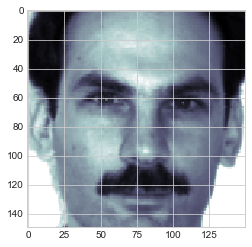

In [46]:
yalefaces_labels = np.array(yalefaces_labels)
yalefaces_cut_images = np.array(yalefaces_cut_images) / 255

print('Label: ', yalefaces_labels[11])
plt.imshow(yalefaces_cut_images[11], cmap='bone');

In [47]:
x_train6, x_test6, y_train6, y_test6 = \
train_test_split(yalefaces_cut_images, yalefaces_labels, test_size = 0.2, random_state = 1)

n = int(len(x_test6)/2)
x_valid6, y_valid6 = x_test6[:n], y_test6[:n]
x_test6, y_test6 = x_test6[n:], y_test6[n:]
print(x_train6.shape, x_valid6.shape, x_test6.shape)
print(y_train6.shape, y_valid6.shape, y_test6.shape)

(132, 150, 150) (16, 150, 150) (17, 150, 150)
(132,) (16,) (17,)


In [48]:
# 210 128x128 flower color images; labeled over 10 categories
flowers = pd.read_csv("flower_images/flower_labels.csv")
flower_files = flowers['file']
flower_targets = flowers['label'].values

In [49]:
def path_to_tensor(img_path):
    img = keras_image.load_img("flower_images/"+img_path, target_size=(128, 128))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True                 

flower_tensors = paths_to_tensor(flower_files) / 255;

100%|██████████| 210/210 [00:10<00:00, 20.40it/s]


In [50]:
x_train7, x_test7, y_train7, y_test7 = \
train_test_split(flower_tensors, flower_targets,  test_size = 0.1, random_state = 1)

n = int(len(x_test7)/2)
x_valid7, y_valid7 = x_test7[:n], y_test7[:n]
x_test7, y_test7 = x_test7[n:], y_test7[n:]
print(x_train7.shape, x_valid7.shape, x_test7.shape)
print(y_train7.shape, y_valid7.shape, y_test7.shape)

(189, 128, 128, 3) (10, 128, 128, 3) (11, 128, 128, 3)
(189,) (10,) (11,)


Label:  0


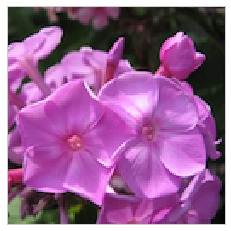

In [51]:
print('Label: ', flower_targets[1])
flower_image = cv2.imread('flower_images/'+flower_files[1])
rgb_flower_image = cv2.cvtColor(flower_image, cv2.COLOR_BGR2RGB)
plt.xticks([]); plt.yticks([])
plt.imshow(rgb_flower_image);

## 3. Preprocessing

In [52]:
# Sequence Padding
p_x_train3 = keras_sequence.pad_sequences(x_train3, maxlen=max_length)
p_x_valid3 = keras_sequence.pad_sequences(x_valid3, maxlen=max_length)
p_x_test3 = keras_sequence.pad_sequences(x_test3, maxlen=max_length)

In [53]:
# One-Hot Encoding
c_y_train1 = to_categorical(y_train1, 10)
c_y_valid1 = to_categorical(y_valid1, 10)
c_y_test1 = to_categorical(y_test1, 10)

c_y_train2 = to_categorical(y_train2, 10)
c_y_valid2 = to_categorical(y_valid2, 10)
c_y_test2 = to_categorical(y_test2, 10)

c_y_train6 = to_categorical(y_train6, 15)
c_y_valid6 = to_categorical(y_valid6, 15)
c_y_test6 = to_categorical(y_test6, 15)

c_y_train7 = to_categorical(y_train7, 10)
c_y_valid7 = to_categorical(y_valid7, 10)
c_y_test7 = to_categorical(y_test7, 10)

## 4. Basic Information

*Optimizers:*

- 'adam', 'nadam', 
- 'adagrad', 'adadelta', 'adamax',
- 'sgd', 'rmsprop',
- TFOptimizer.

*Loss functions:*

- 'mean_squared_error'('mse'), 'mean_absolute_error'('mae'), 
- 'mean_absolute_percentage_error', 'mean_squared_logarithmic_error',
- 'squared_hinge', 'hinge', 'categorical_hinge',
- 'categorical_crossentropy', 'sparse_categorical_crossentropy',
- 'binary_crossentropy',
- 'kullback_leibler_divergence',
- 'poisson',
- 'cosine_proximity',
- 'logcosh'.

*Metrics:*

- mae, mse, acc,
- binary_accuracy, 
- categorical_accuracy, sparse_categorical_accuracy,
- top_k_categorical_accuracy, sparse_top_k_categorical_accuracy.

---

##### Compilation

*For a multi-class classification problem:*

- model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
- model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

*For a binary classification problem:*

- model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
- model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

*For a mean squared error regression problem:*

- model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
- model.compile(optimizer='sgd', loss='mse', metrics=['mae'])
----

##### Activation
- [Neural Networks. CS231](http://cs231n.github.io/neural-networks-1/)

*Types:*

- 'elu', 'selu', 'relu', 'tanh', 'linear', 'softmax', 'softplus', 'softsign', 'sigmoid', 'hard_sigmoid'
- LeakyReLU, PReLU, ELU, ThresholdedReLU

*For a multi-class classification problem:*

- 'softmax'

*For a binary classification problem:*

- 'sigmoid'

*For a mean squared error regression problem:*

- 'linear'

##### Layers

1. *Core Layers*
  - [Keras Documentation. Core Layers](https://keras.io/layers/core/) 
  - `Input` layers hold an input tensor (for example, the pixel values of the image with width 32, height 32, and 3 color channels).
  - `Dense` (fully connected) layers compute the class scores, resulting in volume of size. For example, the size [11] corresponds to class scores, such as 10 digits and 1 empty place. Each neuron in these layers are connected to all the numbers in the previous volume.
  - `Activation` applies an activation function to an output. This leaves the size of the volume unchanged.
  - `Dropout` layers consist in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting. This leaves the size of the volume unchanged.
  - `Reshape` layers convert an output to a certain shape.
  - `Flatten` layers flatten the input and collapses it into the one-dimensional feature vector. This results in the volume such as [2, 30, 64] -> [3840].
  - etc.

2. *Convolutional Layers* 
  - [Keras Documentation. Convolutional Layers](https://keras.io/layers/convolutional/)
  - [Convolutional Neural Networks. Fei-Fei Li & Andrej Karpathy & Justin Johnson](http://cs231n.stanford.edu/slides/2016/winter1516_lecture7.pdf)
  - [Convolutional Neural Networks. Mirella Lapata](https://www.inf.ed.ac.uk/teaching/courses/nlu/lectures/nlu_l15_convolution-2x2.pdf)   
  - `Conv1D` layers (temporal convolution) convolve the filter with the signal, i.e. “is sliding over the signal vector, computing dot products”. Here the filter is an integer, the dimensionality of the output space (i.e. the number output of filters in the convolution) and the kernel size is an integer, specifying the length of the 1D convolution window.
  - `Conv2D` layers (spatial convolution over images) compute the output of neurons that are connected to local regions in the input each computing a dot product between their weights and a small region they are connected to in the input volume. This results in the volume such as [64, 64, 1] -> [64, 64, 32] when it was used 32 filters.
  - `Conv3D` layers (spatial convolution over volumes).
  - `SeparableConv2D`, `Conv2DTranspose`.
  - etc.

3. *Recurrent Layers*
  - `SimpleRNN` layers are fully-connected RNN. This leaves the size of the volume unchanged.
  - `LSTM` layers.
  - `GRU` layers.

4. *Pooling Layers*
  - [Convolutional Neural Networks. CS231](http://cs231n.github.io/convolutional-networks/) 
  - `MaxPooling2D` layers perform a downsampling operation along the spatial dimensions (width, height). Max-pooling partitions the input image into a set of non-overlapping rectangles and, for each such subregion, outputs the maximum value. This results in the volume such as [28, 28, 32] -> [14, 14, 32].
  - `MaxPooling1D` & `MaxPooling3D` is a max pooling operation for temporal (1D) data and spatial or spatio-temporal (3D) data  respectively.
  
5. *Advanced Activations Layers*
  - `LeakyReLU`.
    - $\mathbf {f(x) = alpha * x for x < 0, f(x) = x for x >= 0}$, alpha is a small gradient.
  - `PReLU`.
    - $\mathbf {f(x) = alpha * x for x < 0, f(x) = x for x >= 0}$, alpha is a learned array.
  - `ELU`.
    - $\mathbf {f(x) =  alpha * (exp(x) - 1.) for x < 0, f(x) = x for x >= 0}$, alpha is a small gradient.
  - `ThresholdedReLU`.
    - $\mathbf {f(x) = x for x > theta, f(x) = 0}$ otherwise.
    
etc.

## 5. Basic Examples

In [57]:
# The basic model for binary classification
basic_model = Sequential([Dense(16, input_dim=2),  Activation('relu'), Dense(1),  Activation('sigmoid')])
basic_model.compile(optimizer='adam',  loss='binary_crossentropy',  metrics=['accuracy'])

In [58]:
# Train 
basic_model.fit(x_train5, y_train5, 
                validation_data=(x_valid5, y_valid5), 
                epochs=100, batch_size=128, verbose=0)

# Predict classes
y_test5_predictions = basic_model.predict_classes(x_test5)

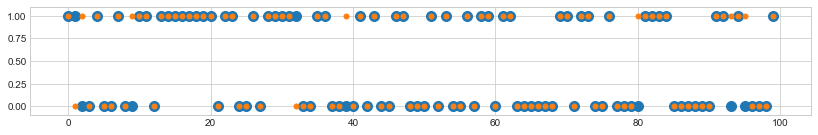

In [59]:
plt.figure(figsize=(14,2))
plt.scatter(range(100), y_test5[:100], s=100)
plt.scatter(range(100), y_test5_predictions[:100], s=25);

In [60]:
# Evaluate
basic_score = basic_model.evaluate(x_test5, y_test5)
basic_score

500/500 [==============================] - 0s 44us/step


[0.1389314285516739, 0.9439999990463257]

In [61]:
# Model parameters
basic_model.input, basic_model.outputs

(<tf.Tensor 'dense_1_input:0' shape=(?, 2) dtype=float32>,
 [<tf.Tensor 'activation_2/Sigmoid:0' shape=(?, 1) dtype=float32>])

In [62]:
basic_model.input_shape, basic_model.output_shape

((None, 2), (None, 1))

In [63]:
basic_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [64]:
basic_model.get_config()

[{'class_name': 'Dense',
  'config': {'activation': 'linear',
   'activity_regularizer': None,
   'batch_input_shape': (None, 2),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dtype': 'float32',
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'name': 'dense_1',
   'trainable': True,
   'units': 16,
   'use_bias': True}},
 {'class_name': 'Activation',
  'config': {'activation': 'relu', 'name': 'activation_1', 'trainable': True}},
 {'class_name': 'Dense',
  'config': {'activation': 'linear',
   'activity_regularizer': None,
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'c

In [65]:
basic_model.get_weights() 

[array([[ 0.09925822, -0.8250601 ,  1.0280185 , -0.78917974, -0.76693577,
          1.2097049 , -0.5525417 , -0.6076799 , -0.14964095,  0.14575952,
         -0.54850155, -0.32459787,  0.74387157, -0.42363188, -0.45986006,
         -0.8186099 ],
        [ 1.0927873 , -0.10296759, -1.0314506 , -0.11693878, -0.13376448,
         -1.1853591 , -0.11369531, -0.09200531,  0.02896296,  1.0351516 ,
          0.12109938, -0.1563327 , -1.0734129 , -0.07054693, -0.4914755 ,
         -0.07361535]], dtype=float32),
 array([ 0.19543295,  0.40398502, -0.12174819,  0.45671332,  0.43987665,
        -0.15403457,  0.4860427 ,  0.52776366,  0.31206858,  0.21048962,
         0.5965124 , -0.07407436, -0.09734194,  0.5791241 , -0.27770907,
         0.42895946], dtype=float32),
 array([[ 0.77585286],
        [-0.46512994],
        [ 0.7959009 ],
        [-0.37247956],
        [-0.6835275 ],
        [ 0.8069941 ],
        [-0.7256957 ],
        [-0.41119534],
        [-0.54048514],
        [ 0.7797967 ],
      

In [66]:
# Save/reload models
# basic_model.save('basic_model.h5')
# basic_model = load_model('basic_model.h5')

In [67]:
# Save/reload weights
# basic_model.save_weights('basic_model_weights.h5')
# basic_model.load_weights('basic_model_weights.h5', by_name=False)

In [69]:
# Choose optimization
optimizer = keras.optimizers.rmsprop(lr=0.001, decay=1e-5)
optimizer = keras.optimizers.Nadam(lr=0.005, beta_1=0.99, beta_2=0.9999, 
                                   epsilon=None, schedule_decay=0.005)

basic_model = Sequential([Dense(16, input_dim=2),  Activation('relu'), Dense(1),  Activation('sigmoid')])
basic_model.compile(optimizer=optimizer,  loss='binary_crossentropy',  metrics=['accuracy'])
basic_model.fit(x_train5, y_train5, 
                validation_data=(x_valid5, y_valid5), 
                epochs=100, batch_size=128, verbose=0)

basic_score = basic_model.evaluate(x_test5, y_test5)
basic_score

500/500 [==============================] - 0s 33us/step


[0.12681850445270537, 0.954]

In [71]:
# Improve activation

# encoder
inp = Input(shape=(2,))
act = keras.layers.LeakyReLU(alpha=0.4)
lay = Dense(16, name='encoder')(inp)
lay = act(lay)

# decoder
out = Dense(1, activation='sigmoid', name='decoder')(lay)

# model
basic_model = Model(inputs=inp, outputs=out, name='cae')
basic_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

basic_model.fit(x_train5, y_train5, 
                validation_data=(x_valid5, y_valid5), 
                epochs=100, batch_size=128, verbose=0)

basic_score = basic_model.evaluate(x_test5, y_test5)
basic_score

500/500 [==============================] - 0s 33us/step


[0.13024811893701554, 0.954]

In [72]:
# Use callbacks

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weights.best.basic_model.hdf5', save_best_only=True)
lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)

basic_model = Model(inputs=inp, outputs=out, name='cae')
basic_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

basic_model.fit(x_train5, y_train5, validation_data=(x_valid5, y_valid5),
                epochs=200, batch_size=128, verbose=0, 
                callbacks=[early_stopping, checkpointer,  lr_reduction])

basic_model.load_weights('weights.best.basic_model.hdf5')
basic_score = basic_model.evaluate(x_test5, y_test5)
basic_score

500/500 [==============================] - 0s 37us/step


[0.12721524745225907, 0.956]

## 6. Neural Networks
### Multi-Layer Perceptrons

In [54]:
# Reshape image arrays
x_train6 = (x_train6).reshape(-1, 150*150)
x_valid6 = (x_valid6).reshape(-1, 150*150)
x_test6 = (x_test6).reshape(-1, 150*150)

In [56]:
# Multi-Class Classification
def model():
    model = Sequential()
    
    model.add(Dense(128, activation='relu', input_shape=(22500,)))
    model.add(Dropout(0.1))
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.1))
    
    model.add(Dense(15, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = model()
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weights.best.model.hdf5', save_best_only=True)
lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, factor=0.5)

history = model.fit(x_train6, c_y_train6, validation_data=(x_valid6, c_y_valid6),
                    epochs=70, batch_size=64, verbose=0,
                    callbacks=[checkpointer,  lr_reduction])

model.load_weights('weights.best.model.hdf5')
test_score = model.evaluate(x_test6, c_y_test6)
test_score


Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
17/17 [==============================] - 0s 1ms/step


[0.35443150997161865, 0.8823529481887817]

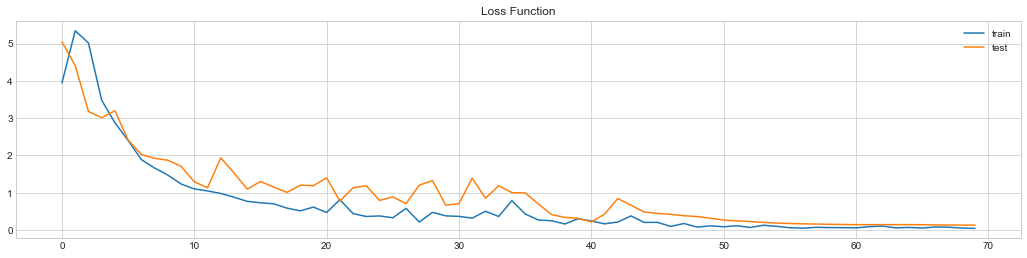

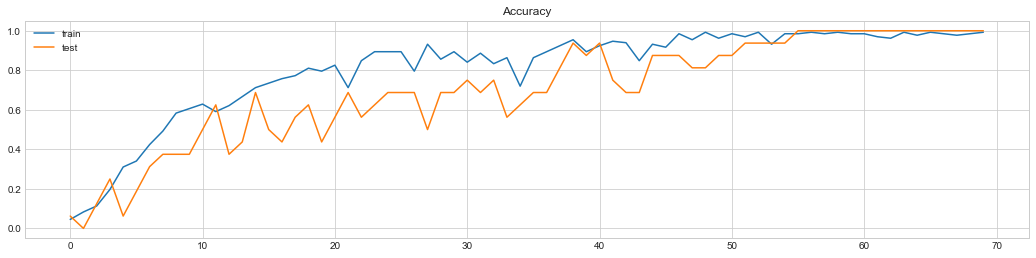

In [57]:
loss_plot(history)
acc_plot(history)

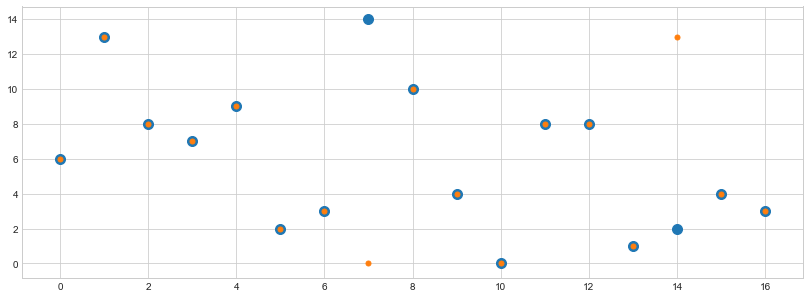

In [58]:
y_test6_predictions = model.predict_classes(x_test6)

plt.figure(figsize=(14,5))
plt.scatter(range(17), y_test6, s=100)
plt.scatter(range(17), y_test6_predictions, s=25);

In [62]:
# MLP: Multi-Class Classification
def model():
    model = Sequential()
    
    model.add(Dense(49, activation='relu', input_shape=(784,)))
    model.add(Dropout(0.1))
    
    model.add(Dense(8*784, activation='relu'))
    model.add(Dropout(0.1))
    
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = model()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weights.best.model.hdf5', save_best_only=True)
lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', verbose=2, patience=5, factor=0.5)

history = model.fit(x_train2.reshape(-1,784), c_y_train2, 
                    validation_data=(x_valid2.reshape(-1,784), c_y_valid2),
                    epochs=70, batch_size=256, verbose=0,
                    callbacks=[early_stopping, checkpointer,  lr_reduction]);


Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00052: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00057: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00062: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 00067: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.


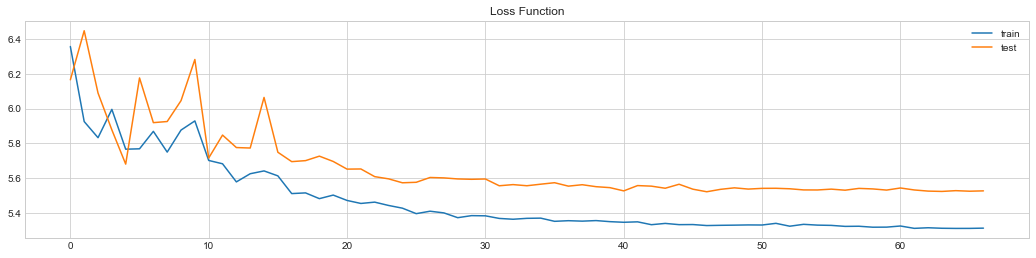

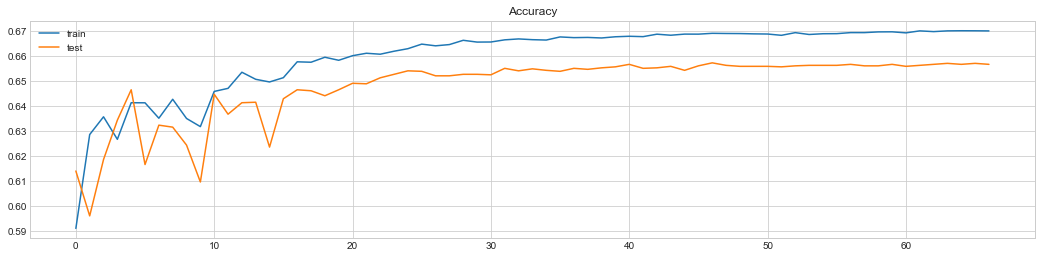

In [63]:
loss_plot(history)
acc_plot(history)

5000/5000 [==============================] - 0s 98us/step


[5.141114578247071, 0.6808]

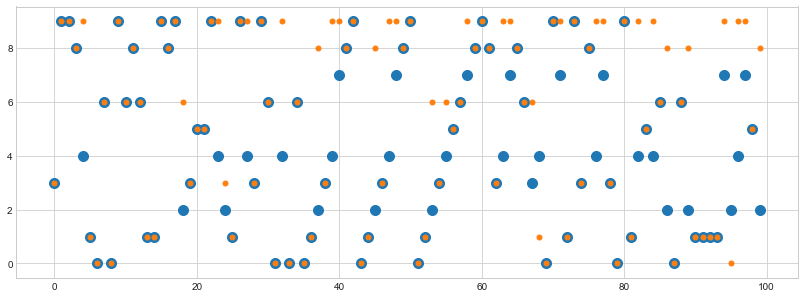

In [64]:
model.load_weights('weights.best.model.hdf5')
y_test2_predictions = model.predict_classes(x_test2.reshape(-1,784))

plt.figure(figsize=(14,5))
plt.scatter(range(100), y_test2[:100], s=100)
plt.scatter(range(100), y_test2_predictions[:100], s=25)

test_score = model.evaluate(x_test2.reshape(-1,784), c_y_test2)
test_score

In [161]:
# Regression
def model():
    model = Sequential()
    
    model.add(Dense(52, activation='relu', input_shape=(13,)))    
    model.add(Dense(52, activation='relu')) 
    
    model.add(Dense(208, activation='relu'))
    model.add(Dense(208, activation='relu'))
    
    model.add(Dense(832, activation='relu'))
    
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])     
    return model

model = model()
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weights.best.model.hdf5', verbose=2, save_best_only=True)
lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, factor=0.5)

history = model.fit(x_train4, y_train4, validation_data=(x_valid4, y_valid4),
                    epochs=100, batch_size=16, verbose=0,
                    callbacks=[checkpointer,  lr_reduction])

model.load_weights('weights.best.model.hdf5')
test_score = model.evaluate(x_test4, y_test4)
test_score


Epoch 00001: val_loss improved from inf to 51.20755, saving model to weights.best.model.hdf5

Epoch 00002: val_loss did not improve from 51.20755

Epoch 00003: val_loss did not improve from 51.20755

Epoch 00004: val_loss did not improve from 51.20755

Epoch 00005: val_loss did not improve from 51.20755

Epoch 00006: val_loss did not improve from 51.20755

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00007: val_loss improved from 51.20755 to 43.92056, saving model to weights.best.model.hdf5

Epoch 00008: val_loss improved from 43.92056 to 41.85145, saving model to weights.best.model.hdf5

Epoch 00009: val_loss did not improve from 41.85145

Epoch 00010: val_loss did not improve from 41.85145

Epoch 00011: val_loss did not improve from 41.85145

Epoch 00012: val_loss did not improve from 41.85145

Epoch 00013: val_loss did not improve from 41.85145

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00014: va

[34.604219848034425, 4.243978883705887]

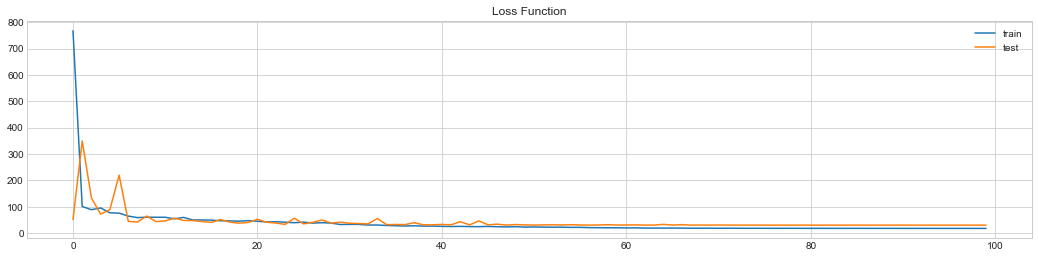

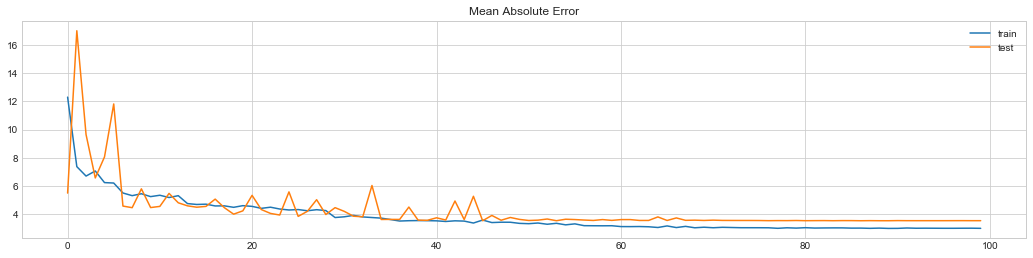

In [162]:
loss_plot(history)
mae_plot(history)

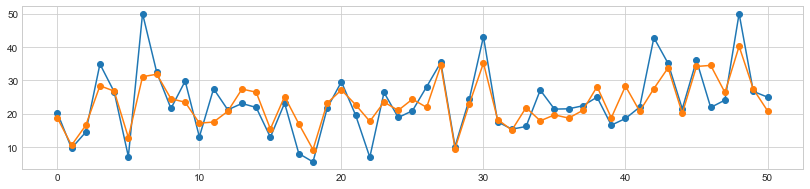

In [163]:
y_test4_predictions = model.predict(x_test4)
plt.figure(figsize=(14,3))
plt.plot(range(len(y_test4)), y_test4, '-o', label = 'real data')
plt.plot(range(len(y_test4)), y_test4_predictions, '-o', label = 'predictions');

### Convolutional Neural Networks (CNN)

In [65]:
# CNN: Binary Classification
def model():
    model = Sequential()
    
    model.add(Conv1D(filters=8, kernel_size=5, padding='same', 
                     activation='relu', input_shape=(2,1)))
    model.add(Conv1D(filters=8, kernel_size=5, 
                     padding='same', activation='relu'))
    
    model.add(MaxPooling1D(pool_size=2))   
    model.add(Dropout(0.1))  

    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])   
    return model

model = model()
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weights.best.model.hdf5', save_best_only=True)
lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, factor=0.5)

history = model.fit(x_train5.reshape(-1, 2, 1), y_train5.reshape(-1, 1, 1), 
                    validation_data=(x_valid5.reshape(-1, 2, 1), y_valid5.reshape(-1, 1, 1)),
                    epochs=20, batch_size=64, verbose=0,
                    callbacks=[checkpointer,  lr_reduction])

model.load_weights('weights.best.model.hdf5')
test_score = model.evaluate(x_test5.reshape(-1, 2, 1), y_test5.reshape(-1, 1, 1))
test_score


Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
500/500 [==============================] - 0s 44us/step


[0.14828426146507262, 0.9459999990463257]

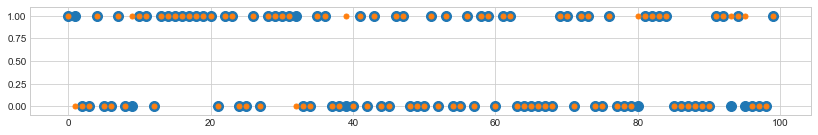

In [66]:
y_test5_predictions = model.predict_classes(x_test5.reshape(-1, 2, 1))
plt.figure(figsize=(14,2))
plt.scatter(range(100), y_test5[:100], s=100)
plt.scatter(range(100), y_test5_predictions[:100], s=25);

In [67]:
# VGG-like CNN: Multi-Class Classification
def model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train1.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(96, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(96, (3, 3)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [68]:
model = model()
checkpointer = keras.callbacks.ModelCheckpoint(filepath='weights.best.model.hdf5',  save_best_only=True)
lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, factor=0.5)

history = model.fit(x_train1, c_y_train1, validation_data=(x_valid1, c_y_valid1),
                    epochs=30, batch_size=128, verbose=0,
                    callbacks=[checkpointer,  lr_reduction])

model.load_weights('weights.best.model.hdf5')
test_score = model.evaluate(x_test1, c_y_test1)
test_score

5000/5000 [==============================] - 14s 3ms/step


[0.821739066696167, 0.7358]

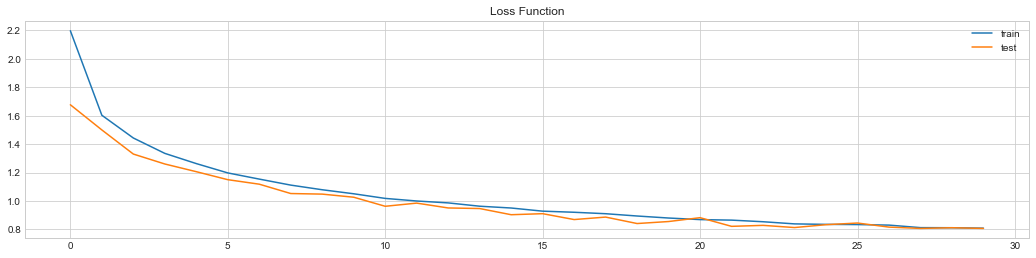

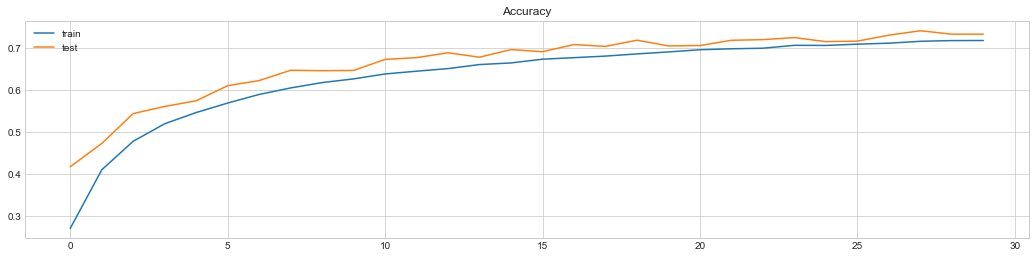

In [69]:
loss_plot(history)
acc_plot(history)

In [70]:
steps, epochs = 1000, 5
data_generator = keras_image.ImageDataGenerator(zoom_range=0.2, horizontal_flip=True)
dg_history = \
model.fit_generator(data_generator.flow(x_train1, c_y_train1, batch_size=128),
                    steps_per_epoch = steps, epochs = epochs, verbose=2, 
                    validation_data = (x_valid1, c_y_valid1),
                    callbacks=[checkpointer, lr_reduction])

model.load_weights('weights.best.model.hdf5')
test_score = model.evaluate(x_test1, c_y_test1)
test_score

Epoch 1/5
 - 1123s - loss: 0.9626 - acc: 0.6683 - val_loss: 0.8603 - val_acc: 0.7036
Epoch 2/5
 - 890s - loss: 0.9466 - acc: 0.6730 - val_loss: 0.8477 - val_acc: 0.7118
Epoch 3/5
 - 884s - loss: 0.9260 - acc: 0.6815 - val_loss: 0.9020 - val_acc: 0.6934
Epoch 4/5
 - 1101s - loss: 0.9109 - acc: 0.6866 - val_loss: 0.8628 - val_acc: 0.7014
Epoch 5/5
 - 1016s - loss: 0.9033 - acc: 0.6885 - val_loss: 0.7767 - val_acc: 0.7380
5000/5000 [==============================] - 12s 2ms/step


[0.7820099027633667, 0.738]

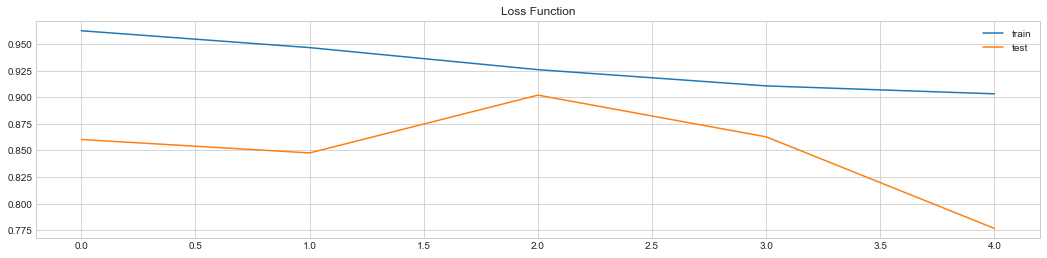

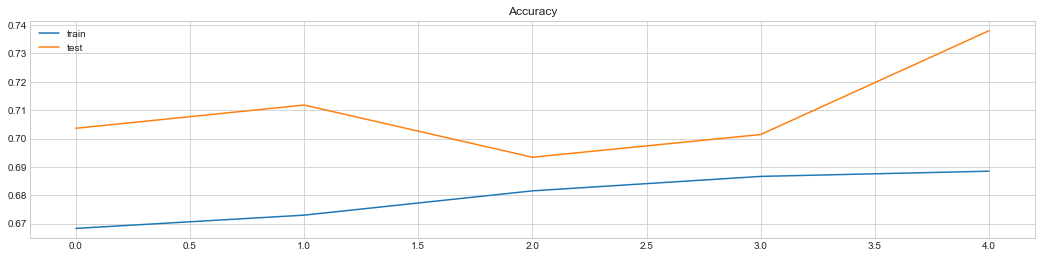

In [71]:
loss_plot(dg_history)
acc_plot(dg_history)

In [72]:
y_valid1_predictions = model.predict_classes(x_valid1)
y_test1_predictions = model.predict_classes(x_test1)

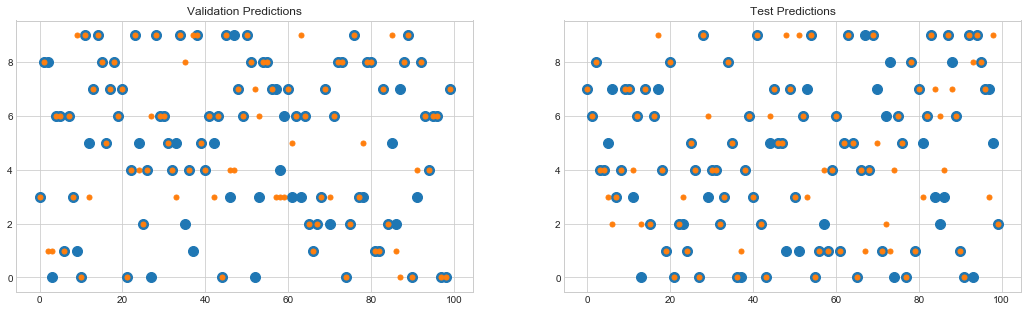

In [73]:
plt.figure(1, figsize=(18, 5))
plt.subplot(121)
plt.scatter(range(100), y_valid1[:100], s=100)
plt.scatter(range(100), y_valid1_predictions[:100], s=25)
plt.title("Validation Predictions")
plt.subplot(122)
plt.scatter(range(100), y_test1[:100], s=100)
plt.scatter(range(100), y_test1_predictions[:100], s=25)
plt.title("Test Predictions");

In [329]:
# CNN: Regression
def cnn_reg_model():
    model = Sequential()
    
#    model.add(BatchNormalization(input_shape=(13,1)))
        
    model.add(Conv1D(13, 5, padding='valid', activation='relu', input_shape=(13,1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv1D(104, 3, padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    
    model.add(Flatten())

    model.add(Dense(832, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(1, kernel_initializer='normal'))
    
#    opt = keras.optimizers.rmsprop(decay=1e-6)
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model    

In [330]:
cnn_reg_model = cnn_reg_model()
cnn_reg_history = cnn_reg_model.fit(x_train4.reshape(404, 13, 1), y_train4, epochs=1600, batch_size=13, verbose=0,
                                    validation_data=(x_test4.reshape(102, 13, 1), y_test4))
y_train4_cnn_predictions = cnn_reg_model.predict(x_train4.reshape(404, 13, 1))
y_test4_cnn_predictions = cnn_reg_model.predict(x_test4.reshape(102, 13, 1))

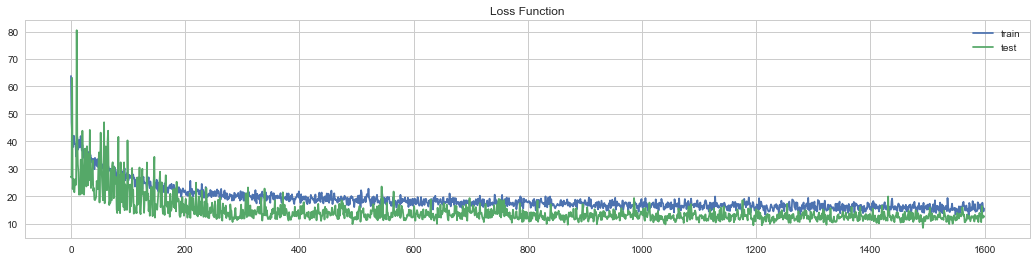

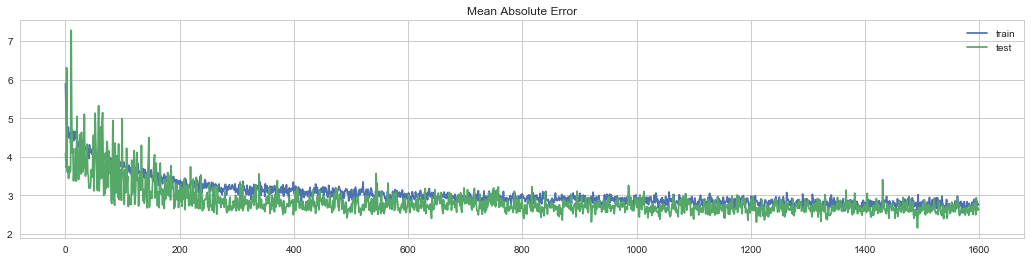

In [331]:
loss_plot(cnn_reg_history)
mae_plot(cnn_reg_history)

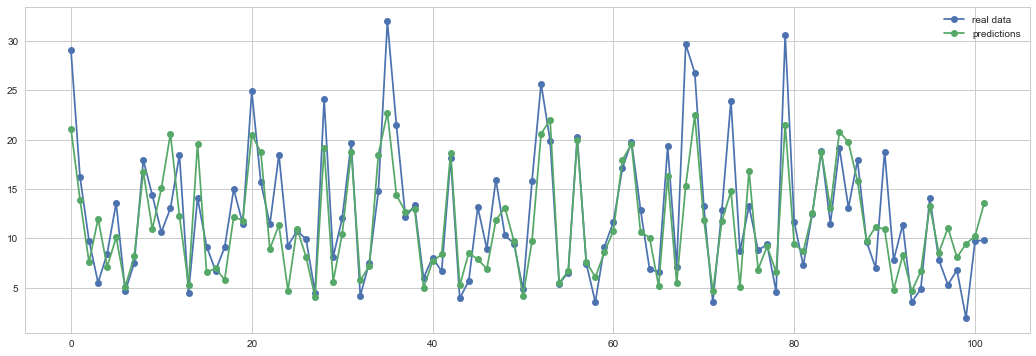

In [324]:
# epochs=400
plt.figure(figsize=(18,6))
plt.plot(range(len(y_test4)), y_test4, '-o', label = 'real data')
plt.plot(range(len(y_test4)), y_test4_cnn_predictions, '-o', label = 'predictions')
plt.legend();

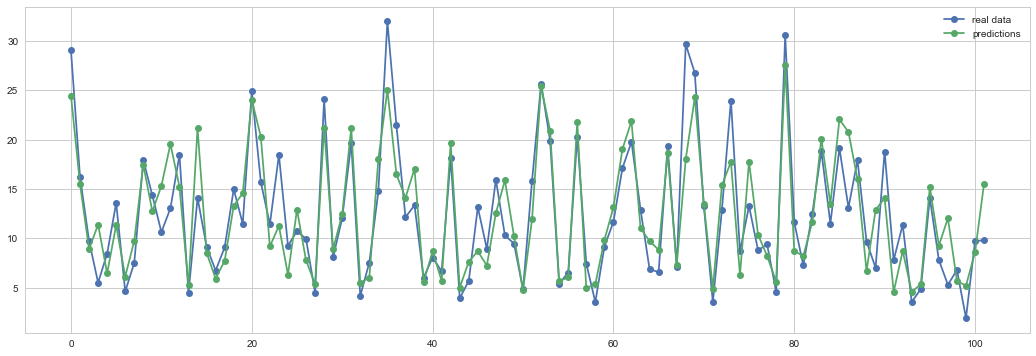

In [328]:
# epochs=800
plt.figure(figsize=(18,6))
plt.plot(range(len(y_test4)), y_test4, '-o', label = 'real data')
plt.plot(range(len(y_test4)), y_test4_cnn_predictions, '-o', label = 'predictions')
plt.legend();

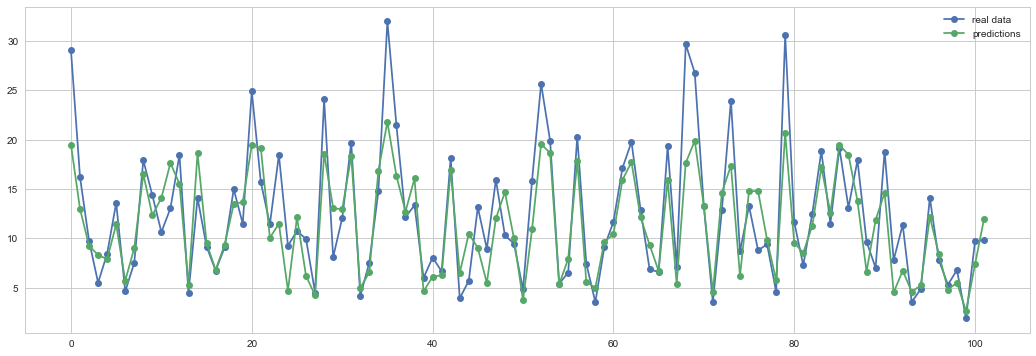

In [332]:
# epochs=1600
plt.figure(figsize=(18,6))
plt.plot(range(len(y_test4)), y_test4, '-o', label = 'real data')
plt.plot(range(len(y_test4)), y_test4_cnn_predictions, '-o', label = 'predictions')
plt.legend();

### Recurrent Neural Network (RNN)

In [182]:
# RNN: Binary Classification
def rnn_bc_model():
    model = Sequential()

    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(1, 2)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])     
    
    return model 

In [183]:
rnn_bc_model = rnn_bc_model()
rnn_bc_history = rnn_bc_model.fit(x_train5.reshape(x_train5.shape[0], 1, x_train5.shape[1]), 
                                  y_train5.reshape(y_train5.shape[0], 1), 
                                  epochs=20, batch_size=32, verbose=2,
                                  validation_data=(x_test5.reshape(x_test5.shape[0], 1, x_test5.shape[1]), 
                                                   y_test5.reshape(y_test5.shape[0], 1)))

y_train5_rnn_predictions = rnn_bc_model.predict_classes(x_train5.reshape(x_train5.shape[0], 1, x_train5.shape[1]))
y_test5_rnn_predictions = rnn_bc_model.predict_classes(x_test5.reshape(x_test5.shape[0], 1, x_test5.shape[1]))

Train on 800 samples, validate on 200 samples
Epoch 1/20
11s - loss: 0.6834 - acc: 0.6088 - val_loss: 0.6673 - val_acc: 0.8150
Epoch 2/20
0s - loss: 0.6551 - acc: 0.8000 - val_loss: 0.6397 - val_acc: 0.8700
Epoch 3/20
0s - loss: 0.6261 - acc: 0.8163 - val_loss: 0.6103 - val_acc: 0.8700
Epoch 4/20
0s - loss: 0.5958 - acc: 0.8212 - val_loss: 0.5792 - val_acc: 0.8500
Epoch 5/20
0s - loss: 0.5737 - acc: 0.8025 - val_loss: 0.5488 - val_acc: 0.8400
Epoch 6/20
0s - loss: 0.5333 - acc: 0.8362 - val_loss: 0.5148 - val_acc: 0.8550
Epoch 7/20
0s - loss: 0.5098 - acc: 0.8325 - val_loss: 0.4837 - val_acc: 0.8500
Epoch 8/20
0s - loss: 0.4862 - acc: 0.8625 - val_loss: 0.4541 - val_acc: 0.8550
Epoch 9/20
0s - loss: 0.4539 - acc: 0.8513 - val_loss: 0.4272 - val_acc: 0.8550
Epoch 10/20
0s - loss: 0.4368 - acc: 0.8612 - val_loss: 0.4042 - val_acc: 0.8550
Epoch 11/20
0s - loss: 0.4074 - acc: 0.8575 - val_loss: 0.3842 - val_acc: 0.8600
Epoch 12/20
0s - loss: 0.4017 - acc: 0.8638 - val_loss: 0.3677 - val_ac

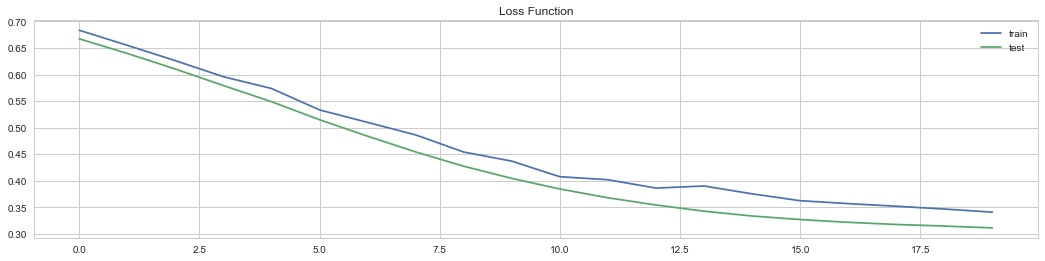

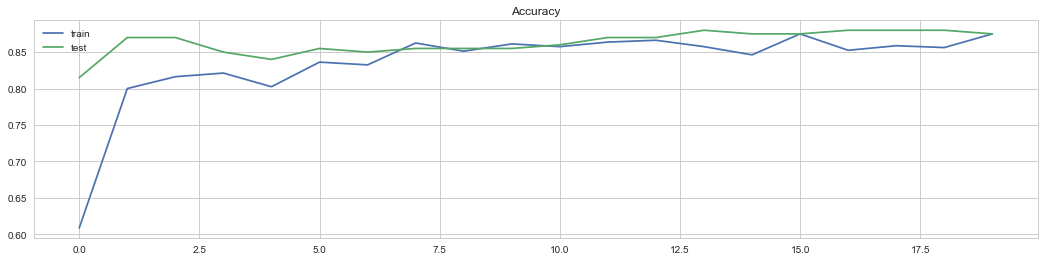

In [184]:
loss_plot(rnn_bc_history)
acc_plot(rnn_bc_history)

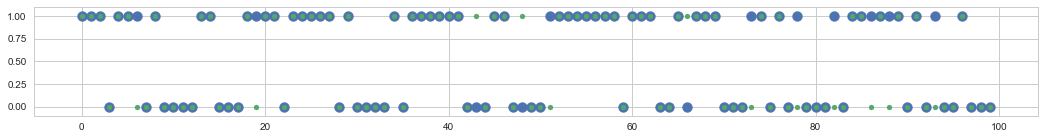

In [185]:
plt.figure(figsize=(18,2))
plt.scatter(range(100), y_test5[:100], s=100)
plt.scatter(range(100), y_test5_rnn_predictions[:100], s=25);

In [120]:
# RNN: Multi-Class Classification
def rnn_mc_model():
    model = Sequential()

    model.add(LSTM(112, return_sequences=True, input_shape=(1,784)))
    
    model.add(LSTM(112, return_sequences=True)) 
    model.add(LSTM(112))  
    
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])    
    return model 


In [121]:
rnn_mc_model = rnn_mc_model()
rnn_mc_history = rnn_mc_model.fit(x_train2.reshape(x_train2.shape[0], 1, x_train2.shape[1]), y_train2, 
                                  epochs=10, batch_size=128, verbose=2,
                                  validation_data=(x_test2.reshape(x_test2.shape[0], 1, x_test2.shape[1]), y_test2))
y_train2_rnn_predictions = rnn_mc_model.predict_classes(x_train2.reshape(x_train2.shape[0], 1, x_train2.shape[1]))
y_test2_rnn_predictions = rnn_mc_model.predict_classes(x_test2.reshape(x_test2.shape[0], 1, x_test2.shape[1]))

Train on 55000 samples, validate on 10000 samples
Epoch 1/10
34s - loss: 0.3061 - acc: 0.9101 - val_loss: 0.1241 - val_acc: 0.9635
Epoch 2/10
24s - loss: 0.1013 - acc: 0.9693 - val_loss: 0.0958 - val_acc: 0.9700
Epoch 3/10
24s - loss: 0.0660 - acc: 0.9802 - val_loss: 0.0915 - val_acc: 0.9721
Epoch 4/10
24s - loss: 0.0468 - acc: 0.9855 - val_loss: 0.0862 - val_acc: 0.9742
Epoch 5/10
24s - loss: 0.0328 - acc: 0.9892 - val_loss: 0.0920 - val_acc: 0.9733
Epoch 6/10
24s - loss: 0.0297 - acc: 0.9905 - val_loss: 0.0895 - val_acc: 0.9766
Epoch 7/10
24s - loss: 0.0228 - acc: 0.9924 - val_loss: 0.0794 - val_acc: 0.9767
Epoch 8/10
24s - loss: 0.0193 - acc: 0.9935 - val_loss: 0.0786 - val_acc: 0.9797
Epoch 9/10
24s - loss: 0.0153 - acc: 0.9951 - val_loss: 0.0992 - val_acc: 0.9745
Epoch 10/10
24s - loss: 0.0161 - acc: 0.9944 - val_loss: 0.0910 - val_acc: 0.9773
 9888/10000 [============================>.] - ETA: 0s   

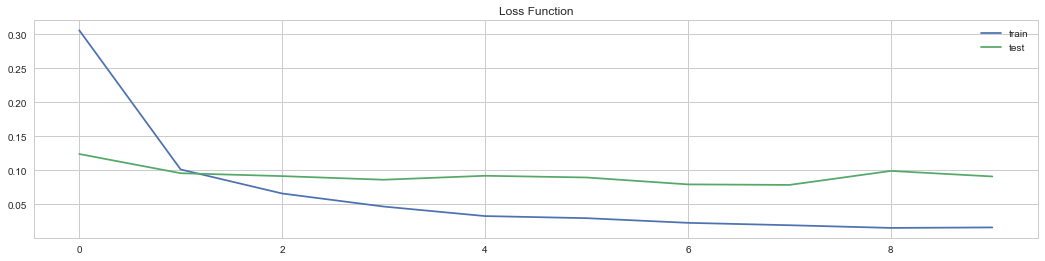

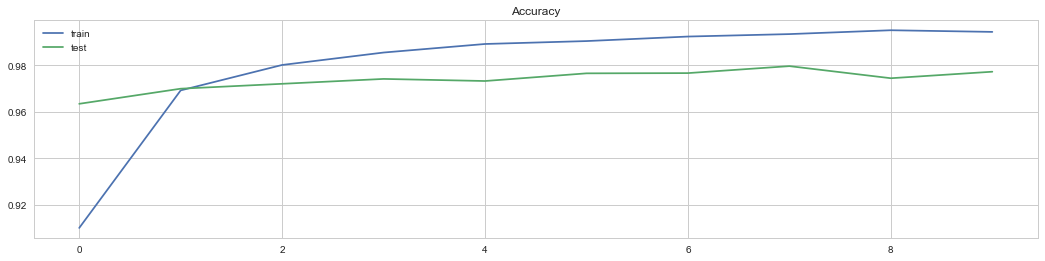

In [124]:
loss_plot(rnn_mc_history)
acc_plot(rnn_mc_history)

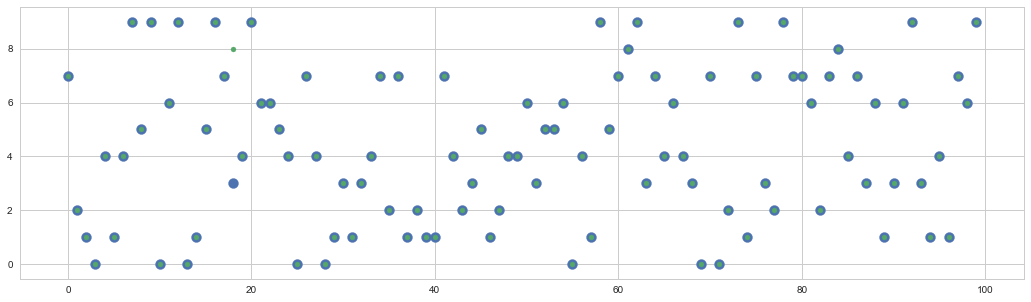

In [125]:
plt.figure(figsize=(18, 5))
plt.scatter(range(100), y_test2_class[:100], s=100)
plt.scatter(range(100), y_test2_rnn_predictions[:100], s=25);

In [201]:
# RNN: Regression
def rnn_reg_model():
    model = Sequential()
    
    model.add(LSTM(52, return_sequences=True, input_shape=(1, 13)))
    model.add(LSTM(208, return_sequences=False))   
    
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) 
    
    return model 

In [202]:
rnn_reg_model = rnn_reg_model()

rnn_reg_history = rnn_reg_model.fit(x_train4.reshape(x_train4.shape[0], 1, x_train4.shape[1]), y_train4, 
                                    validation_data=(x_test4.reshape(x_test4.shape[0], 1, x_test4.shape[1]),y_test4), 
                                    epochs=800, verbose=0)

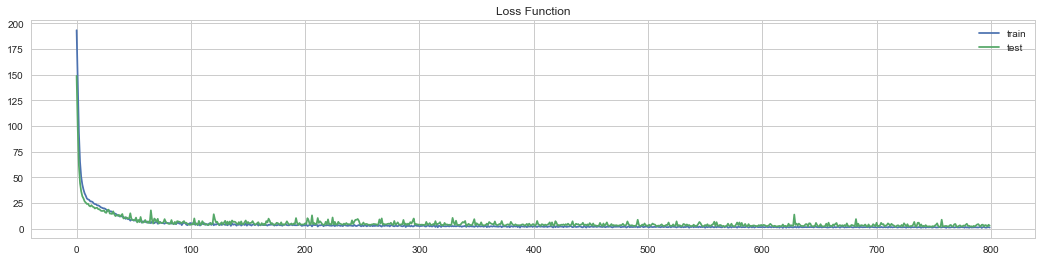

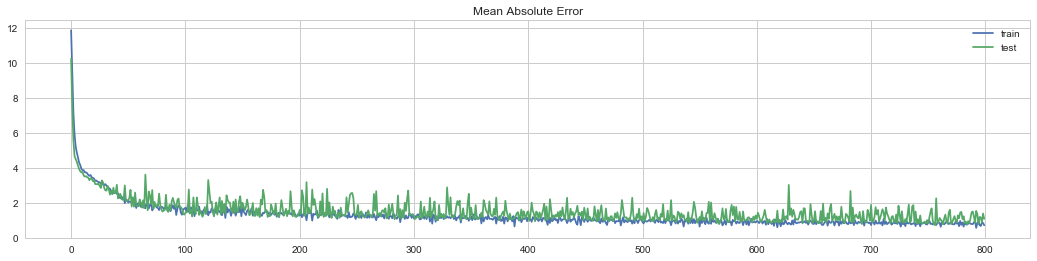

In [203]:
loss_plot(rnn_reg_history)
mae_plot(rnn_reg_history)

In [199]:
y_train4_rnn_predictions = rnn_reg_model.predict(x_train4.reshape(x_train4.shape[0], 1, x_train4.shape[1]))
y_test4_rnn_predictions = rnn_reg_model.predict(x_test4.reshape(102, 1, 13))

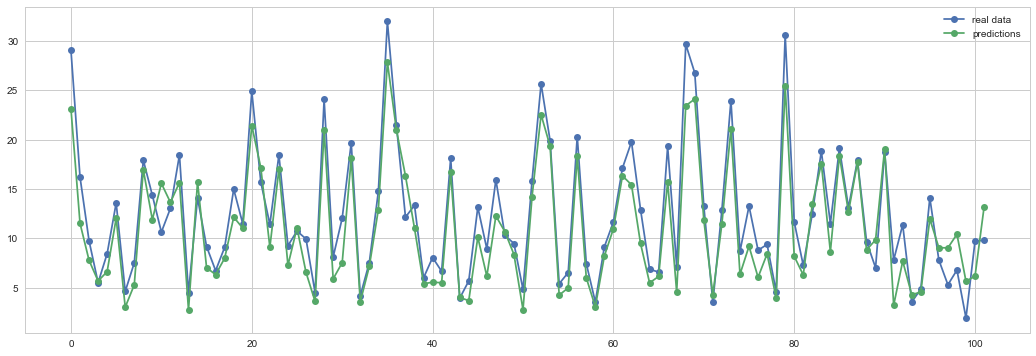

In [181]:
# epochs=50
plt.figure(figsize=(18,6))
plt.plot(range(len(y_test4)), y_test4, '-o', label = 'real data')
plt.plot(range(len(y_test4)), y_test4_rnn_predictions, '-o', label = 'predictions')
plt.legend();

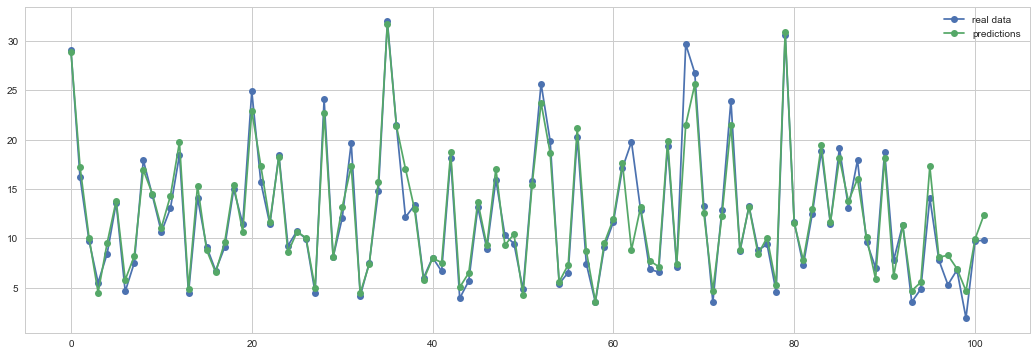

In [200]:
# epochs=200
plt.figure(figsize=(18,6))
plt.plot(range(len(y_test4)), y_test4, '-o', label = 'real data')
plt.plot(range(len(y_test4)), y_test4_rnn_predictions, '-o', label = 'predictions')
plt.legend();

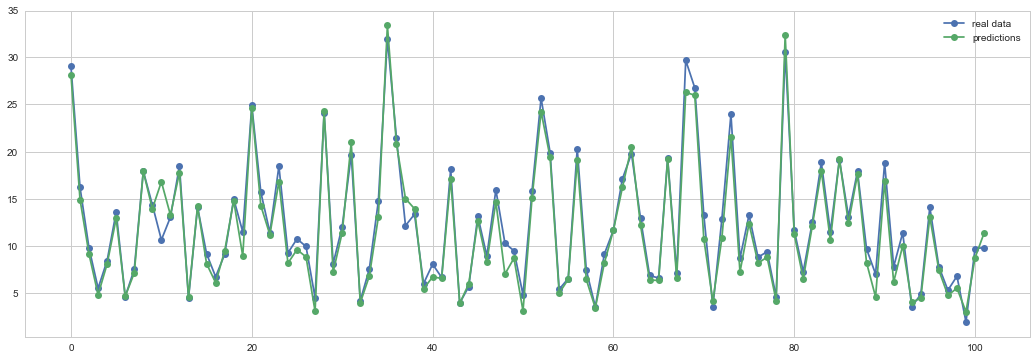

In [195]:
# epochs=800
plt.figure(figsize=(18,6))
plt.plot(range(len(y_test4)), y_test4, '-o', label = 'real data')
plt.plot(range(len(y_test4)), y_test4_rnn_predictions, '-o', label = 'predictions')
plt.legend();

In [70]:
# CNN: LSTM For Sequence Classification
def cnn_lstm_model():
    model = Sequential()

    model.add(Embedding(num_words, embedding_vector_length, input_length=max_length))

    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(LSTM(32))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

In [71]:
cnn_lstm_model = cnn_lstm_model()
cnn_lstm_history = cnn_lstm_model.fit(p_x_train3, y_train3, epochs=3, batch_size=128,
                                      validation_data=(p_x_test3, y_test3))

Train on 25000 samples, validate on 24819 samples
Epoch 1/3
25000/25000 [==============================] - 511s - loss: 0.4403 - acc: 0.7875 - val_loss: 0.3575 - val_acc: 0.8494

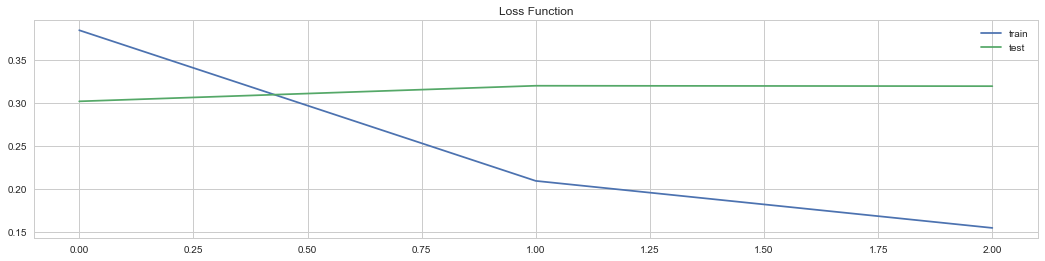

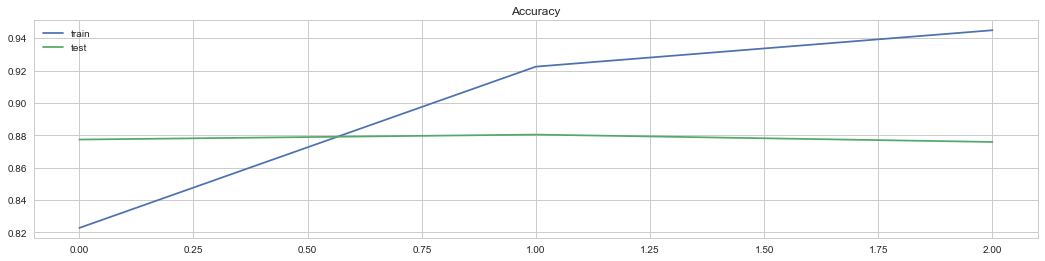

In [69]:
loss_plot(cnn_lstm_history)
acc_plot(cnn_lstm_history)

In [112]:
cnn_lstm_scores = cnn_lstm_model.evaluate(p_x_test3, y_test3, verbose=2)
print("Accuracy: %.2f%%" % (cnn_lstm_scores[1]*100))

Accuracy: 87.09%


## 7. Applications

In [74]:
resnet50_model = ResNet50(weights='imagenet')
# resnet50_model_json = resnet50_model.to_json()

# with open("resnet50.json", "w") as json_file:
#     json_file.write(resnet50_model_json)

# json_file = open('resnet50.json', 'r')
# resnet50_model_json = json_file.read()
# json_file.close()

# resnet50_model = model_from_json(resnet50_model_json)

Predicted: [('n02123394', 'Persian_cat', 0.5807485), ('n02120079', 'Arctic_fox', 0.087616719), ('n02120505', 'grey_fox', 0.044340547), ('n02123045', 'tabby', 0.041976523), ('n02119022', 'red_fox', 0.032001797)]


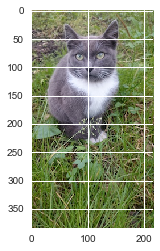

In [85]:
# Classify imagenet_class_index.json classes with ResNet50
cat_image = keras_image.load_img('cat.png', target_size=(224, 224))
CLASS_INDEX = None

x = keras_image.img_to_array(cat_image)
x = np.expand_dims(x, axis=0)
x = resnet50_preprocess_input(x)

cat_predictions = resnet50_model.predict(x)
print('Predicted:', decode_predictions2(cat_predictions, 'imagenet_class_index.json')[0])

cv_cat_image = cv2.imread('cat.png')
rgb_cat_image = cv2.cvtColor(cv_cat_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_cat_image);

In [28]:
# Extract image features with VGG16

# https://github.com/fchollet/deep-learning-models/releases/download/v0.1/
# vgg16_weights_tf_dim_ordering_tf_kernels.h5
# vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

vgg16_model = VGG16(weights='imagenet', include_top=False)
cat_image = keras_image.load_img('cat.png', target_size=(224, 224))

y = keras_image.img_to_array(cat_image)
y = np.expand_dims(y, axis=0)
y = vgg16_preprocess_input(y)

cat_features16 = vgg16_model.predict(y)
np.argmax(cat_features16)

5406

In [48]:
# Create bottleneck features with VGG16
VGG16_model = VGG16(weights='imagenet', include_top=False)
bn_x_train1 = VGG16_model.predict(x_train1)
bn_x_test1 = VGG16_model.predict(x_test1)

In [49]:
np.save('bn_x_train1.npy', bn_x_train1.reshape(bn_x_train1.shape[0], bn_x_train1.shape[3]))
np.save('bn_x_test1.npy', bn_x_test1.reshape(bn_x_test1.shape[0], bn_x_test1.shape[3]))

In [50]:
bn_x_train1l = np.load('bn_x_train1.npy')
bn_x_testl1 = np.load('bn_x_test1.npy')
bn_x_train1 = bn_x_train1.reshape(bn_x_train1.shape[0], 1, 1, bn_x_train1.shape[3])
bn_x_testl = bn_x_test1.reshape(bn_x_test1.shape[0], 1, 1, bn_x_test1.shape[3])

In [76]:
def vgg16_add_model():
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=bn_x_train1.shape[1:]))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(384, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [77]:
vgg16_add_model = vgg16_add_model()

vgg16_checkpointer = ModelCheckpoint(filepath='weights.best.vgg16_add.hdf5', verbose=2, save_best_only=True)

In [78]:
vgg16_add_history = vgg16_add_model.fit(bn_x_train1, c_y_train1, validation_data=(bn_x_test1, c_y_test1),
                                        epochs=50, batch_size=128, callbacks=[vgg16_checkpointer], verbose=0);

Epoch 00000: val_loss improved from inf to 1.36891, saving model to weights.best.vgg16_add.hdf5
Epoch 00001: val_loss improved from 1.36891 to 1.29567, saving model to weights.best.vgg16_add.hdf5
Epoch 00002: val_loss improved from 1.29567 to 1.24210, saving model to weights.best.vgg16_add.hdf5
Epoch 00003: val_loss improved from 1.24210 to 1.20852, saving model to weights.best.vgg16_add.hdf5
Epoch 00004: val_loss improved from 1.20852 to 1.19090, saving model to weights.best.vgg16_add.hdf5
Epoch 00005: val_loss improved from 1.19090 to 1.17337, saving model to weights.best.vgg16_add.hdf5
Epoch 00006: val_loss improved from 1.17337 to 1.17256, saving model to weights.best.vgg16_add.hdf5
Epoch 00007: val_loss improved from 1.17256 to 1.15995, saving model to weights.best.vgg16_add.hdf5
Epoch 00008: val_loss improved from 1.15995 to 1.14964, saving model to weights.best.vgg16_add.hdf5
Epoch 00009: val_loss improved from 1.14964 to 1.12958, saving model to weights.best.vgg16_add.hdf5
Epoc

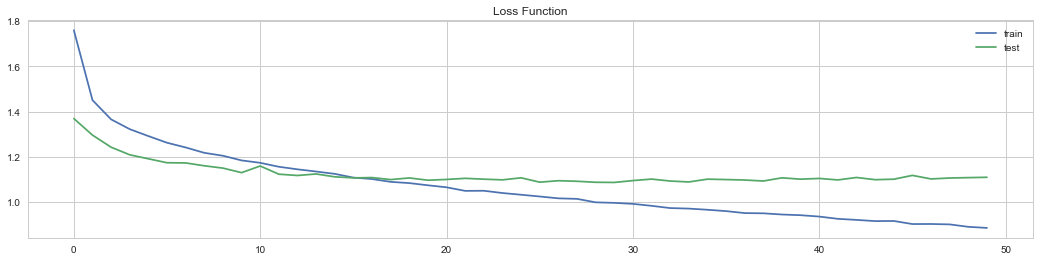

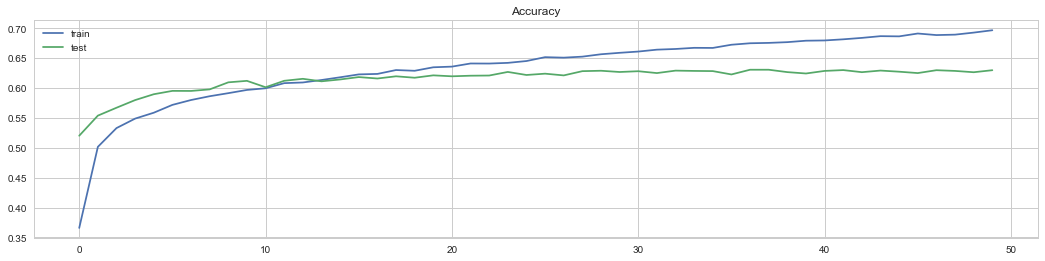

In [79]:
loss_plot(vgg16_add_history)
acc_plot(vgg16_add_history)

In [80]:
vgg16_add_model.load_weights('weights.best.vgg16_add.hdf5')

In [81]:
vgg16_add_predictions = [np.argmax(vgg16_add_model.predict(np.expand_dims(x, axis=0))) for x in bn_x_test1]
vgg16_add_test_accuracy = \
100*np.sum(np.array(vgg16_add_predictions)==np.argmax(c_y_test1, axis=1))/len(vgg16_add_predictions)
print('Test accuracy: %.4f%%' % vgg16_add_test_accuracy)

Test accuracy: 62.6800%


In [58]:
# Extract image features with VGG19

# https://github.com/fchollet/deep-learning-models/releases/download/v0.1/
# vgg19_weights_tf_dim_ordering_tf_kernels.h5
# vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5

vgg19_model = VGG19(weights='imagenet')
cat_image = keras_image.load_img('cat.png', target_size=(224, 224))

z = keras_image.img_to_array(cat_image)
z = np.expand_dims(z, axis=0)
z = vgg19_preprocess_input(z)

cat_features19 = vgg19_model.predict(z)
np.argmax(cat_features19)

281

In [23]:
# InceptionV3 for a new dataset

# https://github.com/fchollet/deep-learning-models/releases/download/v0.1/
# inception_v3_weights_tf_dim_ordering_tf_kernels.h5
# inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

iv3_base_model = InceptionV3(weights='imagenet', include_top=False)
x = iv3_base_model.output

x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)

y = Dense(10, activation='softmax')(x)

iv3_model = Model(inputs=iv3_base_model.input, outputs=y)

In [24]:
# Freeze InceptionV3 convolutional layers
for layer in iv3_base_model.layers:
    layer.trainable = False
    
iv3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])    

In [25]:
steps, epochs = 189, 10
data_generator = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
iv3_checkpointer = ModelCheckpoint(filepath='weights.best.iv3_add.hdf5', verbose=2, save_best_only=True)

In [26]:
iv3_history = iv3_model.fit_generator(data_generator.flow(x_train7, c_y_train7, batch_size=64),
                                      steps_per_epoch = steps, epochs = epochs, 
                                      callbacks=[iv3_checkpointer],verbose=2, 
                                      validation_data = (x_test7, c_y_test7))

Epoch 1/10
Epoch 00000: val_loss improved from inf to 1.44208, saving model to weights.best.iv3_add.hdf5
879s - loss: 0.5143 - acc: 0.8492 - val_loss: 1.4421 - val_acc: 0.7143
Epoch 2/10
Epoch 00001: val_loss improved from 1.44208 to 0.96918, saving model to weights.best.iv3_add.hdf5
945s - loss: 0.1973 - acc: 0.9411 - val_loss: 0.9692 - val_acc: 0.7619
Epoch 3/10
Epoch 00002: val_loss improved from 0.96918 to 0.83739, saving model to weights.best.iv3_add.hdf5
873s - loss: 0.1548 - acc: 0.9508 - val_loss: 0.8374 - val_acc: 0.7143
Epoch 4/10
Epoch 00003: val_loss improved from 0.83739 to 0.77285, saving model to weights.best.iv3_add.hdf5
860s - loss: 0.1205 - acc: 0.9605 - val_loss: 0.7729 - val_acc: 0.7619
Epoch 5/10
Epoch 00004: val_loss did not improve
856s - loss: 0.1047 - acc: 0.9682 - val_loss: 1.5715 - val_acc: 0.7143
Epoch 6/10
Epoch 00005: val_loss did not improve
861s - loss: 0.0973 - acc: 0.9704 - val_loss: 0.9506 - val_acc: 0.7619
Epoch 7/10
Epoch 00006: val_loss did not imp

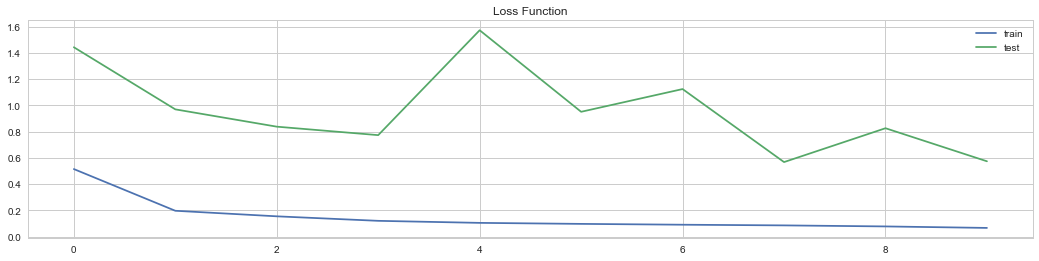

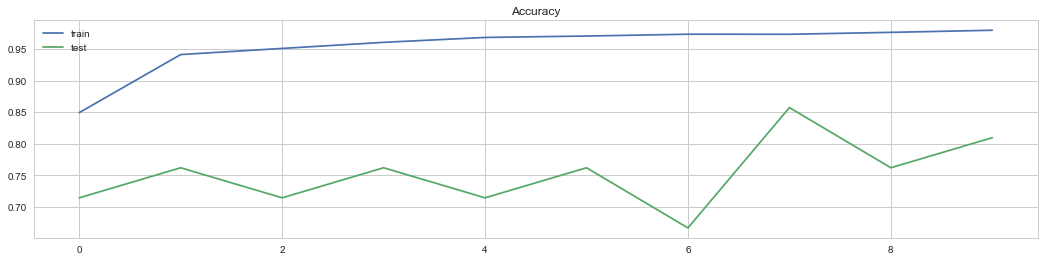

In [28]:
loss_plot(iv3_history)
acc_plot(iv3_history)

In [29]:
for i, layer in enumerate(iv3_base_model.layers[173:]):
    print(i, layer.name)

0 batch_normalization_52
1 batch_normalization_57
2 activation_52
3 activation_57
4 conv2d_53
5 conv2d_58
6 batch_normalization_53
7 batch_normalization_58
8 activation_53
9 activation_58
10 average_pooling2d_6
11 conv2d_51
12 conv2d_54
13 conv2d_59
14 conv2d_60
15 batch_normalization_51
16 batch_normalization_54
17 batch_normalization_59
18 batch_normalization_60
19 activation_51
20 activation_54
21 activation_59
22 activation_60
23 mixed6
24 conv2d_65
25 batch_normalization_65
26 activation_65
27 conv2d_66
28 batch_normalization_66
29 activation_66
30 conv2d_62
31 conv2d_67
32 batch_normalization_62
33 batch_normalization_67
34 activation_62
35 activation_67
36 conv2d_63
37 conv2d_68
38 batch_normalization_63
39 batch_normalization_68
40 activation_63
41 activation_68
42 average_pooling2d_7
43 conv2d_61
44 conv2d_64
45 conv2d_69
46 conv2d_70
47 batch_normalization_61
48 batch_normalization_64
49 batch_normalization_69
50 batch_normalization_70
51 activation_61
52 activation_64
53 act

In [30]:
for layer in iv3_model.layers[:173]:
    layer.trainable = False
for layer in iv3_model.layers[173:]:
    layer.trainable = True
    
iv3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])        

In [31]:
steps, epochs = 189, 10
iv3_history2 = iv3_model.fit_generator(data_generator.flow(x_train7, c_y_train7, batch_size=64),
                                       steps_per_epoch = steps, epochs = epochs, verbose=2, 
                                       validation_data = (x_test7, c_y_test7), 
                                       callbacks=[iv3_checkpointer])

Epoch 1/10
Epoch 00000: val_loss did not improve
1509s - loss: 0.2219 - acc: 0.9731 - val_loss: 6.0787 - val_acc: 0.5238
Epoch 2/10
Epoch 00001: val_loss did not improve
1653s - loss: 0.0988 - acc: 0.9926 - val_loss: 0.6723 - val_acc: 0.8095
Epoch 3/10
Epoch 00002: val_loss did not improve
1519s - loss: 0.1026 - acc: 0.9925 - val_loss: 0.6745 - val_acc: 0.8095
Epoch 4/10
Epoch 00003: val_loss did not improve
1799s - loss: 0.0986 - acc: 0.9933 - val_loss: 0.7072 - val_acc: 0.9048
Epoch 5/10
Epoch 00004: val_loss improved from 0.56773 to 0.54263, saving model to weights.best.iv3_add.hdf5
1601s - loss: 0.1005 - acc: 0.9888 - val_loss: 0.5426 - val_acc: 0.9048
Epoch 6/10
Epoch 00005: val_loss did not improve
1560s - loss: 0.0354 - acc: 0.9945 - val_loss: 0.7254 - val_acc: 0.9048
Epoch 7/10
Epoch 00006: val_loss did not improve
1507s - loss: 0.0246 - acc: 0.9966 - val_loss: 0.8538 - val_acc: 0.9048
Epoch 8/10
Epoch 00007: val_loss improved from 0.54263 to 0.21356, saving model to weights.be

In [32]:
iv3_model.load_weights('weights.best.iv3_add.hdf5')
iv3_test_scores = iv3_model.evaluate(x_test7, c_y_test7)
print("Accuracy: %.2f%%" % (iv3_test_scores[1]*100))

21/21 [==============================] - 2s
Accuracy: 95.24%


In [40]:
# Xception 

# https://github.com/fchollet/deep-learning-models/releases/download/v0.1/
# xception_weights_tf_dim_ordering_tf_kernels.h5
# xception_weights_tf_dim_ordering_tf_kernels_notop.h5

xce_base_model = Xception(include_top=True, weights='imagenet')
xce_base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864         input_5[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________